## Requirements
- numpy (1.13.0)
- scipy (0.19.0)
- matplotlib (2.0.2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import robot1 as r1
from util import *
from planning_algorithms import *

# fix issue of cut off labels
# http://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

D2R = np.pi / 180.0 # conversion constant from deg to rad

In [2]:
# generate three cartesian path in 2D, given in the paper on p. 639
xa, xb, xc = generate_example_paths()

# initial joint configuration for the three paths, also on p. 639
qa_init = np.array([ 0, 20]) * D2R
qb_init = np.array([20, 20]) * D2R
qc_init = np.array([40, 20]) * D2R

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


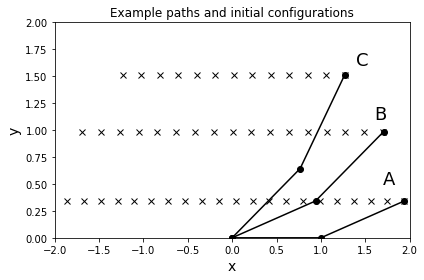

In [3]:
# plot initial configuration
plt.figure()

plt.plot(xa[:, 0], xa[:, 1], 'kx')
plt.plot(xb[:, 0], xb[:, 1], 'kx')
plt.plot(xc[:, 0], xc[:, 1], 'kx')

x2, x1 = r1.fk(qa_init, all_links = True)
plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'ko-')
x2, x1 = r1.fk(qb_init, all_links = True)
plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'ko-')
x2, x1 = r1.fk(qc_init, all_links = True)
plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'ko-')

plt.axis([-2, 2, 0, 2.0])
plt.title('Example paths and initial configurations')
plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)
plt.text(1.7, 0.5, 'A', fontsize = 18)
plt.text(1.6, 1.1, 'B', fontsize = 18)
plt.text(1.4, 1.6, 'C', fontsize = 18)
plt.show()

## Fig. 6: Apply the four algorithms to path A

In [4]:
qa_exact, junk, s = exact_path_following(xa, qa_init, r1.fk)

d = 0.3 # maximum deviation for non-exact algorithms

# Taylors algorithm also needs an ik solution for the last point!
qa_tay, xa_tay, s = taylors_algorithm(xa[0], xa[-1], qa_init, qa_exact[-1], d, r1.fk)

qa_opt, xa_opt, s = local_optimization(xa, qa_init, d, r1.fk, r1.J)

qa_sho, xa_sho, s = trajectory_shortening(xa, qa_exact, d, r1.fk, angle_max = 175.0 * D2R)

Maximum iterations reached in taylor's algorithm


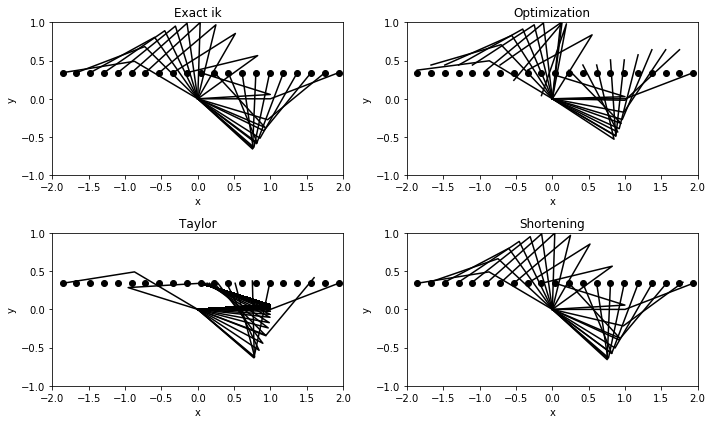

In [5]:
xp = xa
q_exact = qa_exact
q_tay = qa_tay
q_opt = qa_opt
q_sho = qa_sho

av = [-2, 2, -1, 1]

plt.figure(figsize = (10, 6))

plt.subplot(221)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_exact[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact ik')

plt.subplot(222)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_opt[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Optimization')

plt.subplot(223)
plt.axis(av)
for i in range(q_tay.shape[0]):
    x2, x1 = r1.fk(q_tay[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Taylor')

plt.subplot(224)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_sho[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Shortening')

plt.show()

### Path length improvement

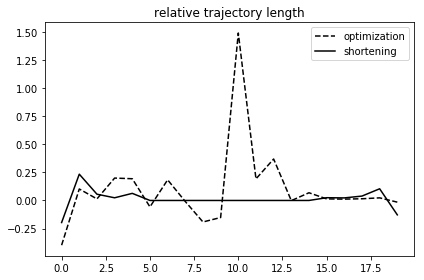

In [6]:
eta_opt = calc_eta(qa_exact, qa_opt)
eta_sho = calc_eta(qa_exact, qa_sho)

plt.figure()
plt.plot(eta_opt, 'k--')
plt.plot(eta_sho, 'k')
plt.legend(['optimization', 'shortening'])
plt.title('relative trajectory length')
plt.show()

## Path B

In [8]:
qb_exact, junk, s = exact_path_following(xb, qb_init, r1.fk)

d = 0.3 # maximum deviation for non-exact algorithms

# Taylors algorithm also needs an ik solution for the last point!
qb_tay, xb_tay, s = taylors_algorithm(xb[0], xb[-1], qb_init, qb_exact[-1], d, r1.fk)

qb_opt, xb_opt, s = local_optimization(xb, qb_init, d, r1.fk, r1.J)

qb_sho, xb_sho, s = trajectory_shortening(xb, qb_exact, d, r1.fk, angle_max = 175.0 * D2R)

Maximum iterations reached in taylor's algorithm


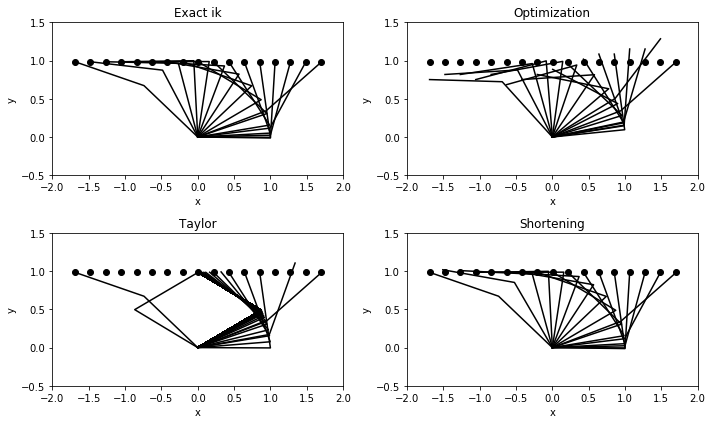

In [9]:
xp = xb
q_exact = qb_exact
q_tay = qb_tay
q_opt = qb_opt
q_sho = qb_sho

av = [-2, 2, -0.5, 1.5]

plt.figure(figsize = (10, 6))

plt.subplot(221)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_exact[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact ik')

plt.subplot(222)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_opt[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Optimization')

plt.subplot(223)
plt.axis(av)
for i in range(q_tay.shape[0]):
    x2, x1 = r1.fk(q_tay[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Taylor')

plt.subplot(224)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_sho[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Shortening')

plt.show()

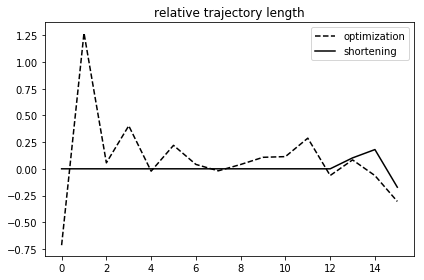

In [10]:
eta_opt = calc_eta(qb_exact, qb_opt)
eta_sho = calc_eta(qb_exact, qb_sho)

plt.figure()
plt.plot(eta_opt, 'k--')
plt.plot(eta_sho, 'k')
plt.legend(['optimization', 'shortening'])
plt.title('relative trajectory length')
plt.show()

## Plan C

In [23]:
q_opt

array([[ 0.34906585,  0.34906585],
       [ 0.48344042,  0.44044539],
       [ 0.19767843,  1.07290369],
       [ 0.15521156,  1.3391141 ],
       [ 0.05132057,  1.66618486],
       [ 0.10543787,  1.8270123 ],
       [ 0.20682174,  1.94626521],
       [ 0.26823578,  2.14664778],
       [ 0.47794896,  2.17493572],
       [ 0.68330555,  2.27020675],
       [ 0.95808861,  2.29460409],
       [ 1.22177905,  2.15444759],
       [ 1.42761184,  1.88626511],
       [ 1.64141267,  1.68032716],
       [ 1.85092776,  1.43383932],
       [ 2.07129997,  1.12933463],
       [ 2.33247252,  0.82557888]])

In [11]:
qc_exact, junk, s = exact_path_following(xc, qc_init, r1.fk)
d = 0.2 # maximum deviation for non-exact algorithms

# Taylors algorithm also needs an ik solution for the last point!
qc_tay, xc_tay, s = taylors_algorithm(xc[0], xc[-1], qc_init, qc_exact[-1], d, r1.fk)

qc_opt, xc_opt, s = local_optimization(xc, qc_init, d, r1.fk, r1.J)

qc_sho, xc_sho, s = trajectory_shortening(xc, qc_exact, d, r1.fk, angle_max = 175.0 * D2R)

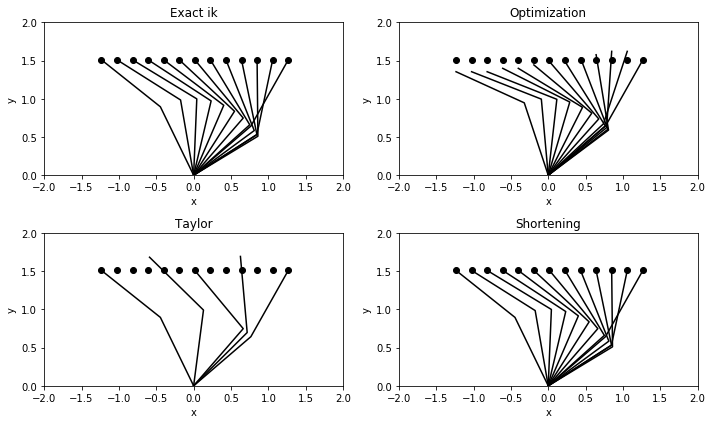

In [12]:
xp = xc
q_exact = qc_exact
q_tay = qc_tay
q_opt = qc_opt
q_sho = qc_sho

av = [-2, 2, 0, 2]

plt.figure(figsize = (10, 6))

plt.subplot(221)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_exact[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact ik')

plt.subplot(222)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_opt[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Optimization')

plt.subplot(223)
plt.axis(av)
for i in range(q_tay.shape[0]):
    x2, x1 = r1.fk(q_tay[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Taylor')

plt.subplot(224)
plt.axis(av)
for i in range(xp.shape[0]):
    x2, x1 = r1.fk(q_sho[i], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'k-')
plt.plot(xp[:, 0], xp[:, 1], 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Shortening')

plt.show()

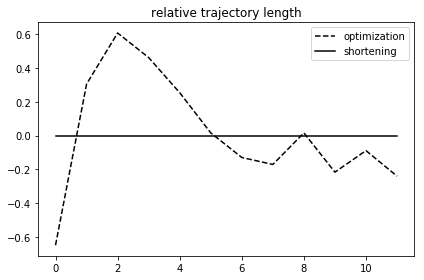

In [13]:
eta_opt = calc_eta(qc_exact, qc_opt)
eta_sho = calc_eta(qc_exact, qc_sho)

plt.figure()
plt.plot(eta_opt, 'k--')
plt.plot(eta_sho, 'k')
plt.legend(['optimization', 'shortening'])
plt.title('relative trajectory length')
plt.show()